In [1]:
# Libraries
import os
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score


Preprocessing

In [2]:
def preprocess_image(image_path, size=(224, 224)):
    img = Image.open(image_path)
    
    # Quality enhancement
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(2.0)  # Increase sharpness
    
    # Noise reduction
    image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Consistency
    img = img.resize(size, Image.LANCZOS)
    
    # Canny edge detection
    image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    edges = cv2.Canny(image, 100, 200)
    img = Image.fromarray(edges)
    
    return img

# Apply preprocessing and save to new directory
input_dir = 'images'
output_dir = 'processed_images'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):
        output_category_path = os.path.join(output_dir, category)
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            preprocessed_img = preprocess_image(image_path)
            preprocessed_img.save(os.path.join(output_category_path, image_name))

Train/Test Split

In [5]:
train_dir = 'processed_images'
test_dir = 'images_train_test_val/test'

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 10500 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.


Base Model Creation

In [6]:
def create_model(optimizer='adam', init_mode='uniform'):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu', kernel_initializer=init_mode))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=init_mode))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init_mode))
    model.add(Dropout(0.5))
    model.add(Dense(21, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

Model Creation

In [ ]:
def model_train_evaluate(optimizer, init_mode, dropout_rate, filters1, filters2, dense_units):
    model = create_model(optimizer=optimizer, init_mode=init_mode, dropout_rate=dropout_rate, filters1=filters1, filters2=filters2, dense_units=dense_units)
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=test_generator,
        verbose=0
    )
    
    val_loss, val_acc = model.evaluate(test_generator, verbose=0)
    return val_acc

In [ ]:
def optimize_model():
    optimizer_dict = {
        'adam': Adam,
        'rmsprop': RMSprop
    }
    
    def model_wrapper(optimizer, init_mode, dropout_rate, filters1, filters2, dense_units):
        optimizer_str = 'adam' if optimizer < 0.5 else 'rmsprop'
        return model_train_evaluate(
            optimizer=optimizer_dict[optimizer_str](),
            init_mode='uniform' if init_mode < 0.5 else 'he_normal',
            dropout_rate=dropout_rate,
            filters1=filters1,
            filters2=filters2,
            dense_units=dense_units
        )
    
    pbounds = {
        'optimizer': (0, 1),
        'init_mode': (0, 1),
        'dropout_rate': (0.3, 0.7),
        'filters1': (16, 64),
        'filters2': (32, 128),
        'dense_units': (64, 256)
    }
    
    optimizer = BayesianOptimization(
        f=model_wrapper,
        pbounds=pbounds,
        random_state=1
    )
    
    optimizer.maximize(init_points=2, n_iter=3)
    
    print("Best hyperparameters found: ", optimizer.max)

optimize_model()

Best Parameters/Model

In [ ]:
# Evaluate the model with the best found parameters
best_params = {
    'optimizer': Adam if optimizer.max['params']['optimizer'] < 0.5 else RMSprop,
    'init_mode': 'uniform' if optimizer.max['params']['init_mode'] < 0.5 else 'he_normal',
    'dropout_rate': optimizer.max['params']['dropout_rate'],
    'filters1': int(optimizer.max['params']['filters1']),
    'filters2': int(optimizer.max['params']['filters2']),
    'dense_units': int(optimizer.max['params']['dense_units'])
}

best_model = create_model(
    optimizer=best_params['optimizer'](),
    init_mode=best_params['init_mode'],
    dropout_rate=best_params['dropout_rate'],
    filters1=best_params['filters1'],
    filters2=best_params['filters2'],
    dense_units=best_params['dense_units']
)

In [ ]:
history = best_model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

Evaluate Model

In [ ]:
train_loss, train_acc = best_model.evaluate(train_generator)
val_loss, val_acc = best_model.evaluate(test_generator)

print(f'Train accuracy: {train_acc:.4f}, Test accuracy: {val_acc:.4f}')

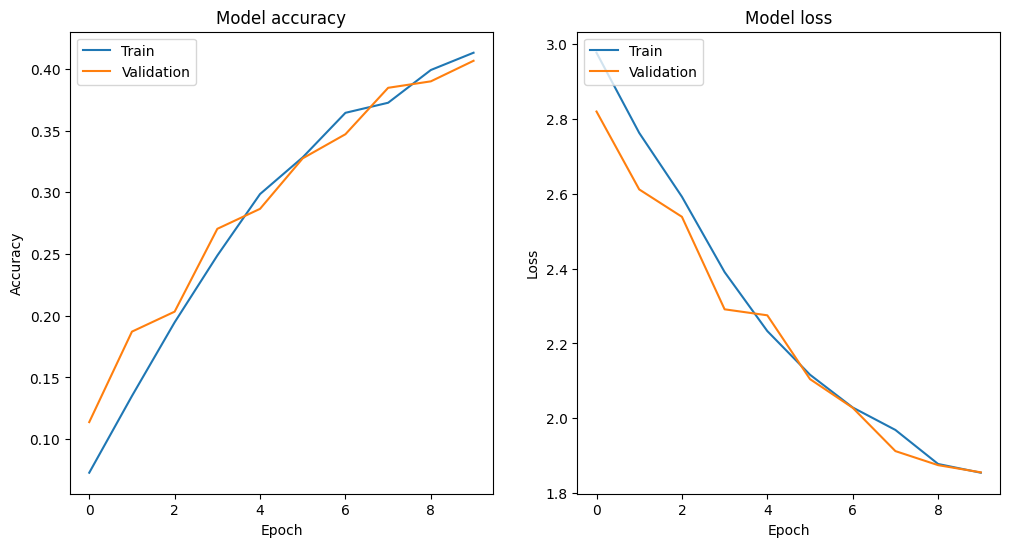

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & Test loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()
